In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("titanic.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  156 non-null    int64  
 1   Survived     156 non-null    int64  
 2   Pclass       156 non-null    int64  
 3   Name         156 non-null    object 
 4   Sex          156 non-null    object 
 5   Age          126 non-null    float64
 6   SibSp        156 non-null    int64  
 7   Parch        156 non-null    int64  
 8   Ticket       156 non-null    object 
 9   Fare         156 non-null    float64
 10  Cabin        31 non-null     object 
 11  Embarked     155 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 14.8+ KB


In [4]:
df['Age'].fillna(df['Age'].median() , inplace = True)
df['Embarked'].fillna(df['Embarked'].mode()[0] , inplace =True)


In [5]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [6]:
df = df[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Cabin', 'Embarked']]

In [7]:
df['Family_total'] = df['SibSp'] + df['Parch'] + 1
df.drop(['SibSp' , 'Parch' , 'Cabin'] , axis = 1 , inplace = True)

In [8]:
df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Family_total
0,0,3,male,22.0,7.2500,S,2
1,1,1,female,38.0,71.2833,C,2
2,1,3,female,26.0,7.9250,S,1
3,1,1,female,35.0,53.1000,S,2
4,0,3,male,35.0,8.0500,S,1


In [9]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder

In [10]:
encoder_sex = LabelEncoder()
df['Sex'] = encoder_sex.fit_transform(df['Sex'])
encoder_embarked = LabelEncoder()
df['Embarked'] = encoder_embarked.fit_transform(df['Embarked'])
df.head()
df_test = df.copy()

In [11]:
df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Family_total'], dtype='object')

In [12]:
X = df[['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Family_total']]
y = df['Survived']

In [13]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size= 0.2 , random_state=2)

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [15]:
models = {
    'Logistic' : LogisticRegression(max_iter=1000 ),
    'SVM' : SVC(),
    'Randomforest' : RandomForestClassifier() , 
    'DecisionTree' : DecisionTreeClassifier() , 
}
result = []
for name , model in models.items():
    scores = np.mean(cross_val_score(model , X , y , cv = 5 , scoring= 'f1_macro'))
    result.append({
        'Model' : name , 
        'Score' : scores , 
    })
df = pd.DataFrame(result)
df = df.sort_values(by = 'Score' , ascending= False , ignore_index= True)
df

,Model,Score
0,Logistic,0.765959
1,Randomforest,0.735955
2,DecisionTree,0.686880
3,SVM,0.395309


# Cải thiện mô hình

In [16]:
model = {
    'Logistic' : LogisticRegression(max_iter=1000 ), 
    'Randomforest' : RandomForestClassifier() 
}
grid_params = {
    'Logistic': {
        'C' : [0.01 , 0.1 , 1 , 10]
    },
    'Randomforest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10]
    }
}
result_final = []
for name , model in model.items() : 
    grid_search = GridSearchCV(model , grid_params[name] , cv = 5 ,  scoring= 'f1_macro' )
    grid_search.fit(X_train , y_train)
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test , y_pred)
    report = classification_report(y_test , y_pred)
    matrix = confusion_matrix(y_test , y_pred)

    result_final.append({
        "Model": name,
        "Accuracy": acc,
        "Best Params": best_params , 
        'cm' : matrix ,
        'report' : report,
        'model' : best_model
    })
df = pd.DataFrame([{'Model' : r['Model'] , 'Acc' : r['Accuracy'] , 'Best' : r['model']} for r in result_final ])
df = df.sort_values(by = 'Acc' , ascending= False , ignore_index= True)
df

,Model,Acc,Best
0,Logistic,0.84375,"LogisticRegression(C=10, max_iter=1000)"
1,Randomforest,0.75000,"(DecisionTreeClassifier(max_features='sqrt', r..."



Mô hình của Logistic


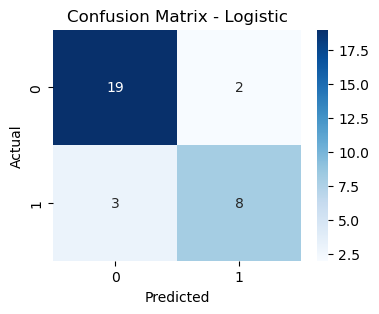

              precision    recall  f1-score   support

           0       0.86      0.90      0.88        21
           1       0.80      0.73      0.76        11

    accuracy                           0.84        32
   macro avg       0.83      0.82      0.82        32
weighted avg       0.84      0.84      0.84        32



In [17]:

for res in result_final:
    if res['Model'] == 'Logistic' : 
        print(f"\nMô hình của {res['Model']}")
        
        plt.figure(figsize=(4, 3))
        sns.heatmap(res['cm'], annot=True, fmt='d', cmap='Blues')
        plt.title(f"Confusion Matrix - {res['Model']}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()
        
        print(res['report'])


In [18]:
model_final = 'N/A'
for res in result_final : 
    if res['Model'] == 'Logistic':
        model_final = res['model']
        print(res['report'])

              precision    recall  f1-score   support

           0       0.86      0.90      0.88        21
           1       0.80      0.73      0.76        11

    accuracy                           0.84        32
   macro avg       0.83      0.82      0.82        32
weighted avg       0.84      0.84      0.84        32



In [19]:
model_final

LogisticRegression(C=10, max_iter=1000)

In [20]:
import joblib 
joblib.dump(model_final , 'best_model.pkl')

['best_model.pkl']

# Test cải tiến 

In [21]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
columns_to_scale = ['Age' , 'Fare' , 'Family_total']
sc.fit(df_test[columns_to_scale])
df_test[columns_to_scale] = sc.transform(df_test[columns_to_scale])


In [22]:
df_test

,Survived,Pclass,Sex,Age,Fare,Embarked,Family_total
0,0,3,1,-0.437089,-0.531122,2,-0.007967
1,1,1,0,0.783472,1.099279,0,-0.007967
2,1,3,0,-0.131949,-0.513935,2,-0.629387
3,1,1,0,0.554617,0.636300,2,-0.007967
4,0,3,1,0.554617,-0.510753,2,-0.629387
...,...,...,...,...,...,...,...
151,1,1,0,-0.437089,0.980034,2,-0.007967
152,0,3,1,2.118462,-0.510753,2,-0.629387
153,0,3,1,0.974185,-0.346524,2,0.613453
154,0,3,1,-0.131949,-0.529531,2,-0.629387


In [23]:
X_train , X_test , y_train , y_test = train_test_split(X , y , random_state= 2 , test_size= 0.2)

In [24]:
grid = {
    'C' : [0.01 , 0.1 , 1 , 10]
}


In [25]:
grid

{'C': [0.01, 0.1, 1, 10]}

In [26]:
grid = GridSearchCV(LogisticRegression() , param_grid= grid , cv = 5 , scoring= 'accuracy')
grid.fit(X_train , y_train)
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test , y_pred))
print(confusion_matrix(y_test , y_pred))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88        21
           1       0.80      0.73      0.76        11

    accuracy                           0.84        32
   macro avg       0.83      0.82      0.82        32
weighted avg       0.84      0.84      0.84        32

[[19  2]
 [ 3  8]]


# Không cải tiến mấy nhưng nên làm kiểu này 